In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import joblib
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense

In [2]:
data = pd.read_csv('diamonds.csv')

In [3]:
#data overview
print(data.head())
print(data.info())
print(data.isnull().sum())

   Unnamed: 0    cut color clarity  carat_weight cut_quality  lab   symmetry  \
0           0  Round     E    VVS2          0.09   Excellent  IGI  Very Good   
1           1  Round     E    VVS2          0.09   Very Good  IGI  Very Good   
2           2  Round     E    VVS2          0.09   Excellent  IGI  Very Good   
3           3  Round     E    VVS2          0.09   Excellent  IGI  Very Good   
4           4  Round     E    VVS2          0.09   Very Good  IGI  Very Good   

      polish eye_clean  ... meas_depth girdle_min  girdle_max  fluor_color  \
0  Very Good   unknown  ...       1.79          M           M      unknown   
1  Very Good   unknown  ...       1.78        STK         STK      unknown   
2  Very Good   unknown  ...       1.77         TN           M      unknown   
3  Very Good   unknown  ...       1.78          M         STK      unknown   
4  Excellent   unknown  ...       1.82        STK         STK      unknown   

   fluor_intensity  fancy_color_dominant_color  fa

In [4]:
#drop unnecessary columns
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])

In [5]:
data = data.drop_duplicates()

In [6]:
data = data.drop(columns=['fluor_color', 'fancy_color_dominant_color', 'fancy_color_secondary_color', 
                          'fancy_color_overtone', 'fancy_color_intensity'])


In [7]:
#encode categorical variables
df = data.copy()
lnc = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = lnc.fit_transform(df[col])
    joblib.dump(lnc, f"{col}.joblib", compress=9)

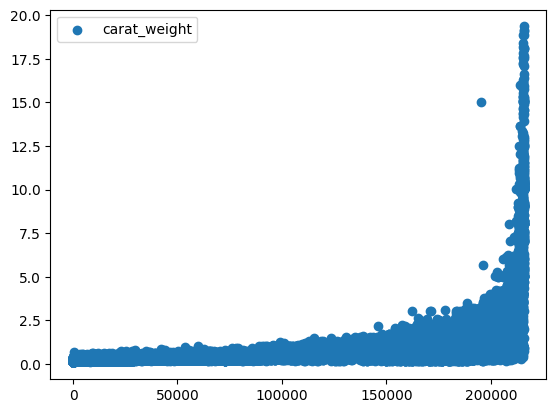

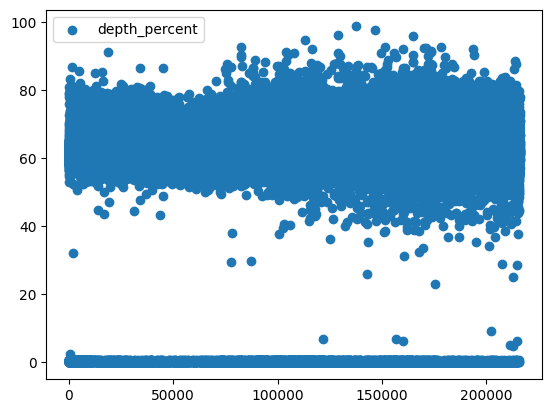

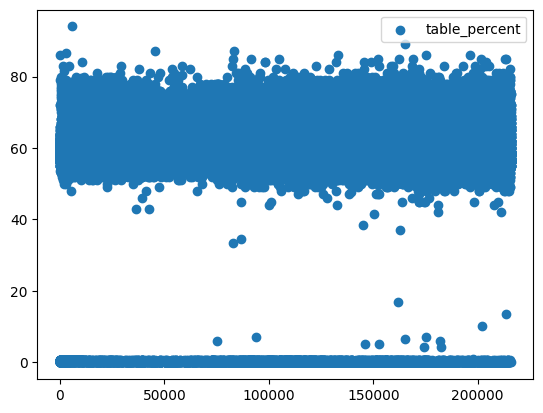

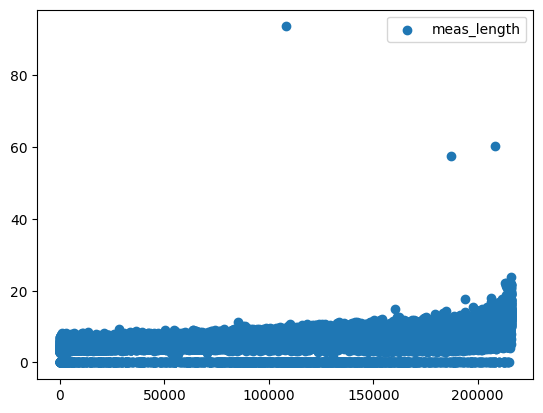

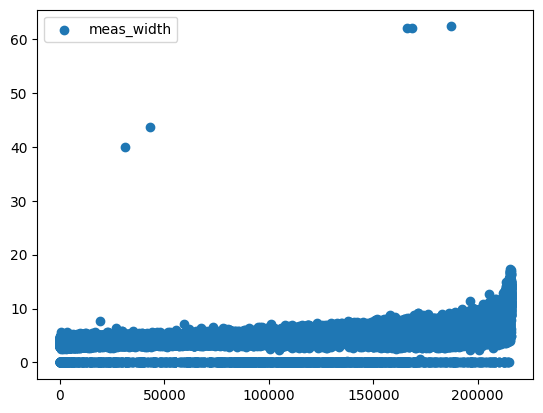

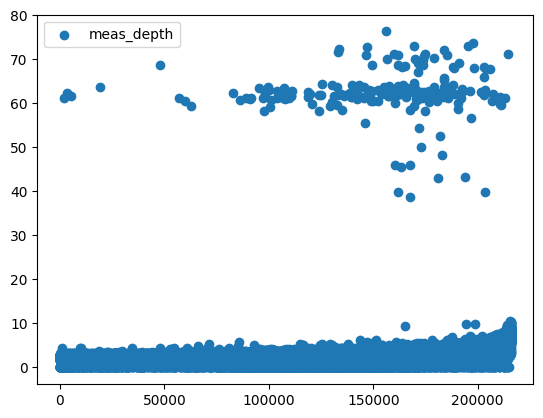

In [8]:
# Visualize float columns
for col in df.select_dtypes(include=['float64']).columns:
    plt.scatter(range(len(df[col])), df[col], label=col)
    plt.legend()
    plt.show()

In [9]:
# Filter out unrealistic measurements
df = df[(df['meas_length'] < 40) & (df['meas_width'] < 30) & (df['meas_depth'] < 30)]
df = df[(df['meas_width'] != 0) & (df['meas_depth'] != 0) & (df['meas_length'] != 0)]
df = df[(df['depth_percent'] != 0) & (df['table_percent'] != 0)]

<Axes: >

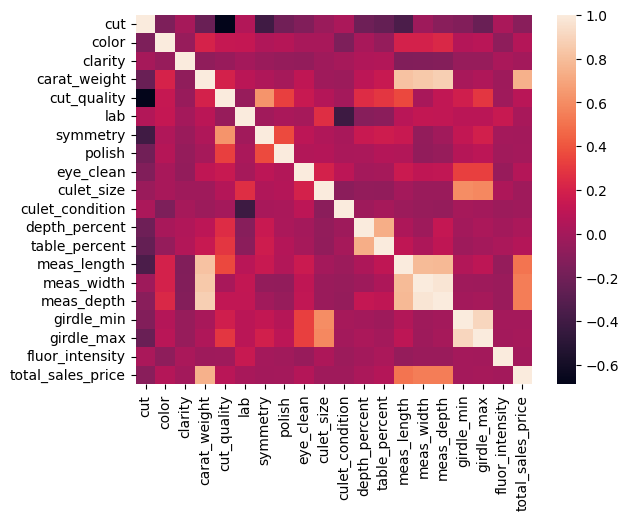

In [10]:
# Correlation heatmap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ss = MinMaxScaler()

corr = df.corr()
sns.heatmap(corr)

In [11]:
# Select features
features = [col for col in df.columns if col != 'total_sales_price']
x = df[features]
y = df['total_sales_price']

In [12]:
# Check feature scores
fs = SelectKBest(f_regression, k='all')
fs.fit(x, y)
for i, score in enumerate(fs.scores_):
    print(f"Feature {features[i]}: {score:.2f}")

Feature cut: 2350.25
Feature color: 762.75
Feature clarity: 7.40
Feature carat_weight: 262560.92
Feature cut_quality: 1256.06
Feature lab: 51.81
Feature symmetry: 15.20
Feature polish: 0.76
Feature eye_clean: 699.84
Feature culet_size: 61.60
Feature culet_condition: 93.90
Feature depth_percent: 178.10
Feature table_percent: 796.56
Feature meas_length: 73702.35
Feature meas_width: 87254.21
Feature meas_depth: 87641.85
Feature girdle_min: 0.25
Feature girdle_max: 9.20
Feature fluor_intensity: 1.74


In [14]:
# Filter top 15 features
fs = SelectKBest(f_regression, k=15)
x_new = fs.fit_transform(x, y)
selected_features = np.array(features)[fs.get_support()]
print(f"Selected Features: {selected_features}")

Selected Features: ['cut' 'color' 'carat_weight' 'cut_quality' 'lab' 'symmetry' 'eye_clean'
 'culet_size' 'culet_condition' 'depth_percent' 'table_percent'
 'meas_length' 'meas_width' 'meas_depth' 'girdle_max']


In [15]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=40)

In [16]:
# Linear Regression
mlr = LinearRegression()
mlr.fit(x_train, y_train)

LinearRegression()

In [17]:
print('Intercept:', mlr.intercept_)
print('Coefficients:', list(zip(selected_features, mlr.coef_)))

Intercept: 44567.29470844884
Coefficients: [(np.str_('cut'), np.float64(570.0448231831019)), (np.str_('color'), np.float64(-616.7199638172518)), (np.str_('carat_weight'), np.float64(39833.17689831144)), (np.str_('cut_quality'), np.float64(-7.5689997563205225)), (np.str_('lab'), np.float64(-2453.4350053811513)), (np.str_('symmetry'), np.float64(24.30580870389022)), (np.str_('eye_clean'), np.float64(417.5550152297971)), (np.str_('culet_size'), np.float64(10.398560259410829)), (np.str_('culet_condition'), np.float64(-3367.1053596904103)), (np.str_('depth_percent'), np.float64(271.11957795543026)), (np.str_('table_percent'), np.float64(-354.45622208477744)), (np.str_('meas_length'), np.float64(-3179.473346020509)), (np.str_('meas_width'), np.float64(3884.767863924158)), (np.str_('meas_depth'), np.float64(-18629.699261737518)), (np.str_('girdle_max'), np.float64(21.736486976307987))]


In [18]:
# Neural Network Model
model = Sequential([
    Dense(units=100, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'),
    Dense(units=50, kernel_initializer='normal', activation='relu'),
    Dense(units=1, kernel_initializer='normal')
])

c:\Projects\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=2000, epochs=50, verbose=1)

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 825821888.0000 - val_loss: 689489536.0000
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 701600512.0000 - val_loss: 655377216.0000
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 638971968.0000 - val_loss: 638403200.0000
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 697959104.0000 - val_loss: 635813056.0000
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 648929792.0000 - val_loss: 632464256.0000
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 734631232.0000 - val_loss: 627240448.0000
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 752468864.0000 - val_loss: 618677184.0000
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 716825024.0000 - val_loss: 603650624.0000
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 597087040.0000 - val_loss: 578387648.0000
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 573505408.0000 - val_loss: 542810688.0

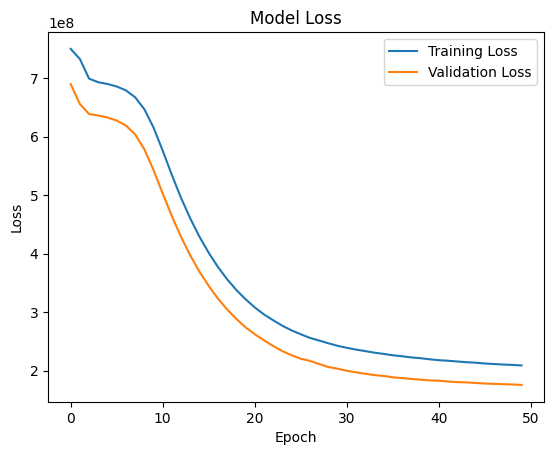

In [20]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
# Predictions and evaluation
pred = model.predict(x_test)
r2 = r2_score(y_test, pred) * 100
print("R squared:", r2)

1316/1316 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
R squared: 72.15421795845032


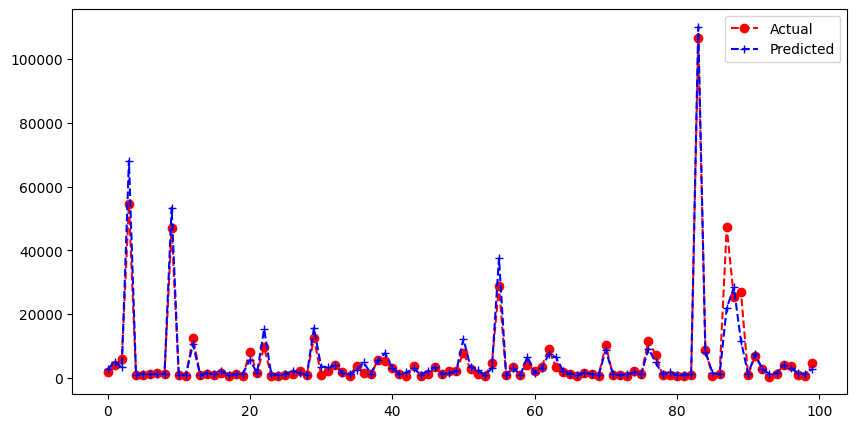

In [22]:
# Compare actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[0:100], 'ro--', label='Actual')
plt.plot(pred[0:100], 'b+--', label='Predicted')
plt.legend()
plt.show()

In [23]:
# Save the model
model.save('tf_m_1.0.0.h5')

In [24]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae']  # 'mae' is a shorthand for mean_absolute_error
)
